# Fairness Analysis: German Credit Dataset

## Multi-Sensitive Exhaustive Evaluation

This notebook analyzes individual fairness on the German Credit dataset using **multi-sensitive exhaustive counterfactual evaluation**.

**Dataset:** German Credit (UCI/OpenML)
- **Task:** Predict credit risk (good/bad)
- **Sensitive feature:** `personal_status` (4 categories combining gender + marital status)
- **Samples:** 1,000

**Approach:** Train models WITH sensitive features and evaluate consistency across ALL demographic categories.

## 0. Setup & Configuration

### 0.1 Environment Setup

Run the cell below **once** to create and configure the conda environment. After running, restart the kernel and select `individual-fairness` from the kernel dropdown.


In [7]:
# 0.1 ENVIRONMENT SETUP 

import subprocess
import sys

ENV_NAME = "fairness"
PYTHON_VERSION = "3.10"

def setup_environment():
    """Create conda environment and install requirements."""
    
    print(f"{'='*60}")
    print(f"Setting up conda environment: {ENV_NAME}")
    print(f"{'='*60}\n")
    
    # Check if environment already exists
    result = subprocess.run(
        ["conda", "env", "list"], 
        capture_output=True, text=True
    )
    
    if ENV_NAME in result.stdout:
        print(f"  Environment '{ENV_NAME}' already exists.")
        response = input("Reinstall? (y/n): ").strip().lower()
        if response != 'y':
            print("Skipping setup. Select the kernel and continue.")
            return
        # Remove existing environment
        subprocess.run(["conda", "env", "remove", "-n", ENV_NAME, "-y"])
    
    # Create new conda environment
    print(f"\n Creating conda environment with Python {PYTHON_VERSION}...")
    subprocess.run([
        "conda", "create", "-n", ENV_NAME, 
        f"python={PYTHON_VERSION}", "-y"
    ], check=True)
    
    # Get conda environment path
    result = subprocess.run(
        ["conda", "run", "-n", ENV_NAME, "which", "pip"],
        capture_output=True, text=True
    )
    pip_path = result.stdout.strip()
    
    # Install requirements
    print("\n Installing requirements...")
    subprocess.run([
        pip_path, "install", "-r", "../requirements.txt"
    ], check=True)
    
    # Install ipykernel for Jupyter
    print("\nInstalling Jupyter kernel...")
    subprocess.run([
        pip_path, "install", "ipykernel"
    ], check=True)
    
    # Register kernel
    subprocess.run([
        "conda", "run", "-n", ENV_NAME, "python", "-m", 
        "ipykernel", "install", "--user", 
        "--name", ENV_NAME, 
        "--display-name", f"Python ({ENV_NAME})"
    ], check=True)
    
    print(f"\n{'='*60}")
    print(f" Setup complete!")
    print(f"{'='*60}")
    print(f"\n Next steps:")
    print(f"   1. Restart the kernel (Kernel → Restart)")
    print(f"   2. Select kernel: 'Python ({ENV_NAME})'")
    print(f"   3. Re-run the notebook from the imports cell")

# comment the line below not to run setup
setup_environment()

Setting up conda environment: fairness

  Environment 'fairness' already exists.
Skipping setup. Select the kernel and continue.


In [33]:
# 0.1 IMPORTS & SETUP

import sys
sys.path.insert(0, '../src')

import warnings
warnings.filterwarnings('ignore')

# For development - reload modules
import importlib
for mod_name in ["datasets", "metrics", "utils.plotting", "utils.analysis", "main"]:
    try:
        mod = importlib.import_module(mod_name)
        importlib.reload(mod)
    except:
        pass

# Standard imports
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
from sklearn.metrics import accuracy_score, balanced_accuracy_score

# Project imports - Main
from main import (
    run_optimization,
    get_pareto_front,
    create_rf_model,
    create_mlp_model,
)

# Project imports - Datasets
from datasets import (
    load_dataset,
    split_data,
    get_dataset_config,
    create_flipped_data_multi_sensitive_exhaustive,
    counterfactual_consistency_multi_sensitive_exhaustive,
)

# Project imports - Plotting
from utils.plotting import (
    plot_and_display_pareto,
    plot_parallel_coords_all_models,
    plot_mds_all_models,
    print_pareto_summary,
    plot_sensitive_distribution,
)

# Project imports - Analysis
from utils.analysis import (
    save_smac_results,
    load_smac_results,
    select_balanced_pareto_point,
)


### 0.2 Configuration

Global configuration variables for the analysis. 

In [20]:
# 0.2 GLOBAL CONFIGURATION

# Dataset
DATASET_NAME = "german_credit"

# Output directories
OUTPUT_DIR = "../plots"
CACHE_DIR = "../cache"

# Data split settings (used by split_data function)
TEST_SIZE = 0.2    # 20% for test
VAL_SIZE = 0.25    # 25% of remaining = 20% of total for validation
RANDOM_STATE = 42

# Create directories
for dir_path in [OUTPUT_DIR, f"{OUTPUT_DIR}/notebook", f"{OUTPUT_DIR}/latex", CACHE_DIR]:
    os.makedirs(dir_path, exist_ok=True)

# Get dataset info
config = get_dataset_config(DATASET_NAME)

print(f"{'='*60}")
print(f"GLOBAL CONFIGURATION")
print(f"{'='*60}")
print(f"  Dataset: {config.name}")
print(f"  OpenML ID: {config.openml_id}")
print(f"  Output directory: {OUTPUT_DIR}")
print(f"  Cache directory: {CACHE_DIR}")

GLOBAL CONFIGURATION
  Dataset: German Credit
  OpenML ID: 31
  Output directory: ../plots
  Cache directory: ../cache


### 0.3 Caching Configuration

Caching mechanism for SMAC optimization results. This allows re-running analysis without repeating time-consuming optimization:

- **`LOAD_FROM_CACHE = True`**: Load previously saved results
- **`LOAD_FROM_CACHE = False`**: Run fresh optimization and save results

Cached results are stored in the `cache/` directory as pickle files.

### 0.4 Reproducibility

Set random seeds for all libraries to ensure reproducible results across runs.

In [ ]:
# 0.2 GLOBAL CONFIGURATION

import random

# ============================================
# REPRODUCIBILITY - Set all random seeds
# ============================================
RANDOM_STATE = 42

# Python random
random.seed(RANDOM_STATE)

# NumPy
np.random.seed(RANDOM_STATE)

# PyTorch (for SenSeI)
try:
    import torch
    torch.manual_seed(RANDOM_STATE)
    torch.cuda.manual_seed_all(RANDOM_STATE)
    # For deterministic behavior on GPU (may slow down training)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    if torch.backends.mps.is_available():
        # MPS (Mac GPU) doesn't have a separate seed, uses torch.manual_seed
        pass
except ImportError:
    pass

# Environment variable for some libraries
os.environ['PYTHONHASHSEED'] = str(RANDOM_STATE)

print(f"✓ Random seed set to {RANDOM_STATE} for reproducibility")

✓ Random seed set to 42 for reproducibility
GLOBAL CONFIGURATION
  Dataset: German Credit
  Random seed: 42
  Output directory: ../plots


## 1. Multi-Sensitive Exhaustive Evaluation

### Overview

We evaluate individual fairness by checking if model predictions are **consistent across ALL categories** of the sensitive feature `personal_status`.

**`personal_status` categories:**
| Category | Description |
|----------|-------------|
| `male div/sep` | Male, divorced/separated |
| `female div/dep/mar` | Female, divorced/dependent/married |
| `male single` | Male, single |
| `male mar/wid` | Male, married/widowed |

**Evaluation approach:**
- For each sample, check predictions for ALL 4 demographic categories
- Compare original prediction against 3 counterfactual predictions
- **Consistency** = fraction where ALL 3 counterfactuals match the original

### Models

1. **Random Forest (RF)** — Standard model with `personal_status` included
2. **MLP** — Neural network with `personal_status` included
3. **SenSeI** — IBM's Sensitive Set Invariance:
   - Learns invariance to `personal_status` variations
   - Uses fair distance metric in training loss

### Key Questions

- Can models achieve high accuracy while being consistent across gender/marital status?
- Does SenSeI's in-training fairness outperform standard models?
- What are the accuracy-fairness trade-offs on this smaller dataset?

### 1.1 Configuration & Setup

Configure the sensitive feature for multi-sensitive exhaustive evaluation.

In [21]:
# 1.1 CONFIGURATION - APPROACH 3 (Multiclass Exhaustive)

# Sensitive feature (multiclass)
SENSITIVE_FEATURE = "personal_status"

# Categories (one-hot encoded columns after preprocessing)
PERSONAL_STATUS_CATEGORIES = [
    "personal_status_male div/sep",
    "personal_status_female div/dep/mar", 
    "personal_status_male single",
    "personal_status_male mar/wid",
]

# Thresholds for Pareto visualization
MIN_ACCURACY = 0.6
MIN_CONSISTENCY = 0.6

# Caching
LOAD_FROM_CACHE = False

# SMAC optimization settings
WALLTIME_LIMIT = 3600  # 1 hour (seconds)
N_TRIALS = 5000

print(f"{'='*60}")
print("APPROACH 3 CONFIGURATION (Multiclass Exhaustive)")
print(f"{'='*60}")
print(f"  Dataset: {DATASET_NAME}")
print(f"  Sensitive feature: {SENSITIVE_FEATURE}")
print(f"  Categories: {len(PERSONAL_STATUS_CATEGORIES)}")
for cat in PERSONAL_STATUS_CATEGORIES:
    print(f"    - {cat.replace('personal_status_', '')}")
print(f"  Comparisons per sample: {len(PERSONAL_STATUS_CATEGORIES) - 1}")
print(f"  SMAC walltime: {WALLTIME_LIMIT} seconds ({WALLTIME_LIMIT//60} minutes)")
print(f"  SMAC max trials: {N_TRIALS}")
print(f"  Caching: {'Enabled' if LOAD_FROM_CACHE else 'Disabled'}")

APPROACH 3 CONFIGURATION (Multiclass Exhaustive)
  Dataset: german_credit
  Sensitive feature: personal_status
  Categories: 4
    - male div/sep
    - female div/dep/mar
    - male single
    - male mar/wid
  Comparisons per sample: 3
  SMAC walltime: 3600 seconds (60 minutes)
  SMAC max trials: 5000
  Caching: Disabled


### 1.2 Load Data

Load the German Credit dataset with `personal_status` as the sensitive feature. The feature remains in the training data (one-hot encoded into 4 columns).

In [11]:
# 1.2 LOAD DATA - GERMAN CREDIT

# Load dataset with sensitive feature included
data = load_dataset(
    DATASET_NAME,
    sensitive_feature=SENSITIVE_FEATURE,
    approach=3,  # Keep sensitive features in training
)

# Apply train/val/test split
data = split_data(data)

# Get feature names to find column indices
feature_names = data['feature_names']

# Find indices for personal_status (multiclass - 4 one-hot columns)
personal_status_col_indices = []
for cat in PERSONAL_STATUS_CATEGORIES:
    try:
        idx = feature_names.index(cat)
        personal_status_col_indices.append(idx)
    except ValueError:
        print(f"Warning: {cat} not found in features")

# Create sensitive_features_info for multi-sensitive evaluation
data['sensitive_features_info'] = [
    {'name': 'personal_status', 'col_indices': personal_status_col_indices},
]

print(f"\n{'='*60}")
print(f"GERMAN CREDIT | Multi-Sensitive Exhaustive")
print(f"{'='*60}")
print(f"  Train:      {len(data['X_train']):,}")
print(f"  Validation: {len(data['X_val']):,}")
print(f"  Test:       {len(data['X_test']):,}")
print(f"  Features:   {data['X_train'].shape[1]}")
print(f"\n  Sensitive feature indices:")
print(f"    - personal_status: {personal_status_col_indices}")

# Show distribution of categories
X = data['X_train']
print(f"\n  Personal status distribution (training set):")
for i, cat in enumerate(PERSONAL_STATUS_CATEGORIES):
    n_cat = int(X[:, personal_status_col_indices[i]].sum())
    cat_name = cat.replace('personal_status_', '')
    print(f"    - {cat_name}: {n_cat:,} ({100*n_cat/len(X):.1f}%)")

print(f"\n  Exhaustive evaluation:")
print(f"    - Total categories: {len(PERSONAL_STATUS_CATEGORIES)}")
print(f"    - Comparisons per sample: {len(PERSONAL_STATUS_CATEGORIES) - 1}")
print(f"    - Total comparisons: {len(data['X_val']):,} × {len(PERSONAL_STATUS_CATEGORIES)-1} = {len(data['X_val'])*(len(PERSONAL_STATUS_CATEGORIES)-1):,}")

Loading German Credit from OpenML (ID: 31)...
APPROACH 3: Keeping sensitive features in training (with SenSeI distance learning)
  Sensitive feature for counterfactual: personal_status
Original features: ['checking_status', 'duration', 'credit_history', 'purpose', 'credit_amount', 'savings_status', 'employment', 'installment_commitment', 'personal_status', 'other_parties', 'residence_since', 'property_magnitude', 'age', 'other_payment_plans', 'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone', 'foreign_worker']

Multiclass sensitive feature: personal_status
  Columns (4): ['personal_status_male div/sep', 'personal_status_female div/dep/mar', 'personal_status_male single', 'personal_status_male mar/wid']
  Indices: [37, 38, 39, 40]

Final features (61): ['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'num_dependents', 'checking_status_<0', 'checking_status_0<=X<200', 'checking_status_>=200']...

Dataset loaded (A

[notebook] Distribution plot saved to: ../plots/notebook/distribution_german_credit_personal_status.png


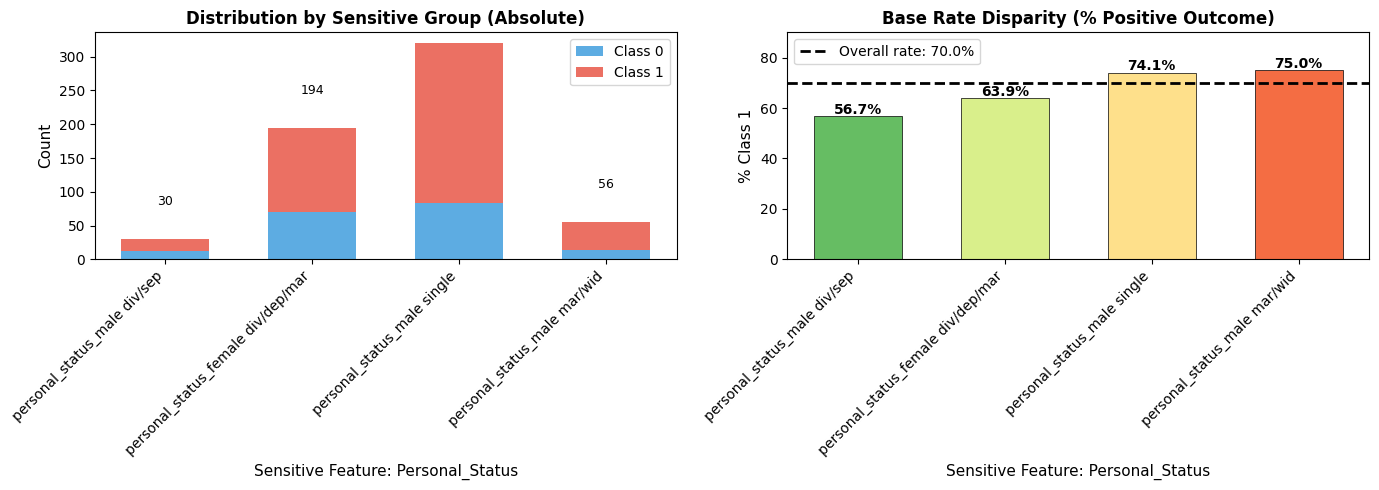

[latex] Distribution plot saved to: ../plots/latex/distribution_german_credit_personal_status.png

DISTRIBUTION SUMMARY

Sensitive Feature: personal_status (4 categories)
Group                Count    % of Data    Base Rate
--------------------------------------------------
personal_status_male div/sep         30         5.0%        56.7%
personal_status_female div/dep/mar        194        32.3%        63.9%
personal_status_male single        320        53.3%        74.1%
personal_status_male mar/wid         56         9.3%        75.0%
--------------------------------------------------
OVERALL                600       100.0%        70.0%

 Disparity Analysis:
   • Highest base rate: 75.0%
   • Lowest base rate:  56.7%
   • Disparity ratio:   1.32x
   • Absolute gap:      18.3 percentage points


{'notebook': '../plots/notebook/distribution_german_credit_personal_status.png',
 'latex': '../plots/latex/distribution_german_credit_personal_status.png'}

In [31]:
# 1.2b DATA EXPLORATION - PERSONAL STATUS

plot_sensitive_distribution(data, DATASET_NAME, SENSITIVE_FEATURE, OUTPUT_DIR)

### 1.3 Multi-Objective Optimization

Run SMAC optimization for models trained **with the sensitive feature** and evaluated on **all demographic categories**.

**Models:**
- **RF/MLP**: Standard models with full feature set (including `personal_status`)
- **SenSeI**: Learns invariance to `personal_status` variations

**Counterfactual Evaluation:**
For each sample, check predictions across all 4 categories of `personal_status`:
- Compare original prediction against 3 counterfactual predictions
- Consistency = fraction where ALL 3 match the original

**Key Question:** How do models trade off accuracy vs fairness on this credit dataset?

In [ ]:
# 1.3 SMAC OPTIMIZATION - MULTI-SENSITIVE EXHAUSTIVE

WALLTIME_LIMIT = 540  # 20 minutes (smaller dataset)
N_TRIALS = 10000
LOAD_FROM_CACHE_OPT = False

CACHE_KEY = f"{DATASET_NAME}_{SENSITIVE_FEATURE}_exhaustive"

# Run optimization OR load from cache
if LOAD_FROM_CACHE:
    print("Loading results from cache...")
    results = load_smac_results(DATASET_NAME, CACHE_KEY, approach=4)
    if results is None:
        print("  No cache found. Running optimization...")
        LOAD_FROM_CACHE_OPT = False
    else:
        print(f"  Loaded models: {list(results.keys())}")
        LOAD_FROM_CACHE_OPT = True
else:
    LOAD_FROM_CACHE_OPT = False

if not LOAD_FROM_CACHE_OPT:
    print("Running SMAC optimization (Multi-Sensitive Exhaustive)...")
    results = {}
    
    # SenSeI FIRST (Individual Fairness Training)
    print(f"\n{'='*60}")
    print(f"Optimizing SenSeI (Multi-Sensitive: personal_status)")
    print(f"{'='*60}")
    
    smac_sensei = run_optimization(
        model_type="sensei",
        data=data,
        walltime_limit=WALLTIME_LIMIT,
        n_trials=N_TRIALS,
        output_dir="../smac_output",
        approach=4,  # Multi-sensitive exhaustive
    )
    results["sensei"] = smac_sensei
    
    # Standard models
    for model_type in ["rf", "mlp"]:
        print(f"\n{'='*60}")
        print(f"Optimizing {model_type.upper()} (Multi-Sensitive)")
        print(f"{'='*60}")
        
        smac = run_optimization(
            model_type=model_type,
            data=data,
            walltime_limit=WALLTIME_LIMIT // 2,
            n_trials=N_TRIALS // 2,
            output_dir="../smac_output",
            approach=4,
        )
        results[model_type] = smac
    
    print("\n" + "="*60)
    print("Optimization Complete!")
    print(f"Models optimized: {list(results.keys())}")
    print("="*60)
    
    # Save results to cache
    save_smac_results(results, DATASET_NAME, CACHE_KEY, approach=4)

Running SMAC optimization (Multi-Sensitive Exhaustive)...

Optimizing SenSeI (Multi-Sensitive: personal_status)

Running SMAC optimization for SENSEI (Approach 4)
Training samples: 600
Validation samples: 200
Using MULTI-SENSITIVE exhaustive counterfactual
  Sensitive features: ['personal_status']
  Total combinations: 4
Using MPS (Mac GPU) acceleration
[INFO][abstract_initial_design.py:74] Using `n_configs` and ignoring `n_configs_per_hyperparameter`.
[INFO][abstract_initial_design.py:139] Using 5 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:517] Added config 8c81c8 as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:604] Config d0bbed is a new incumbent. Total number of incumbents: 2.
[INFO][abstract_intensifier.py:596] Added config f64a07 and rejected config 8c81c8 as incumbent because it is not better than the incumbents on 3 instances: 
[INFO][abstract_intensifier.py:604] Config 5ec971 is a new incum

### 3.4 Results & Visualization

#### Pareto Front Analysis

Compare the accuracy-fairness trade-offs for models evaluated with **multi-sensitive exhaustive counterfactuals**:

| Model | Training | Fairness Mechanism |
|-------|----------|-------------------|
| **RF** | Standard | Implicit (post-hoc evaluation) |
| **MLP** | Standard | Implicit (post-hoc evaluation) |
| **SenSeI** | Fair distance metric | Explicit (learned invariance to sex + race) |

**Evaluation:** Counterfactual consistency using ALL (sex, race) combinations:
- Each sample compared against 9 other demographic combinations
- Stricter than single-attribute evaluation
- Reveals intersectional fairness issues

In [25]:
# 1.4a PARETO SUMMARY

print_pareto_summary(results)


PARETO FRONT SUMMARY

SENSEI Pareto Front (3 configurations):
--------------------------------------------------
  Config 1: Accuracy=0.7075, Consistency=0.9967
  Config 2: Accuracy=0.5373, Consistency=0.9994
  Config 3: Accuracy=0.5016, Consistency=1.0000

  Best Accuracy: 0.7075 (Consistency: 0.9967)
  Best Consistency: 1.0000 (Accuracy: 0.5016)

RF Pareto Front (10 configurations):
--------------------------------------------------
  Config 1: Accuracy=0.6619, Consistency=0.9883
  Config 2: Accuracy=0.6619, Consistency=0.9883
  Config 3: Accuracy=0.6619, Consistency=0.9883
  Config 4: Accuracy=0.6571, Consistency=0.9917
  Config 5: Accuracy=0.6571, Consistency=0.9917
  Config 6: Accuracy=0.6274, Consistency=0.9950
  Config 7: Accuracy=0.6238, Consistency=1.0000
  Config 8: Accuracy=0.6238, Consistency=1.0000
  Config 9: Accuracy=0.6238, Consistency=1.0000
  Config 10: Accuracy=0.6238, Consistency=1.0000

  Best Accuracy: 0.6619 (Consistency: 0.9883)
  Best Consistency: 1.0000 (Accu

In [32]:
results

{'sensei': <smac.facade.hyperparameter_optimization_facade.HyperparameterOptimizationFacade at 0x31fb910f0>,
 'rf': <smac.facade.hyperparameter_optimization_facade.HyperparameterOptimizationFacade at 0x31f95f4c0>,
 'mlp': <smac.facade.hyperparameter_optimization_facade.HyperparameterOptimizationFacade at 0x31f8ab640>}

[notebook] Pareto plot saved to: ../plots/notebook/pareto_german_credit_personal_status_exhaustive.png
[latex] Pareto plot saved to: ../plots/latex/pareto_german_credit_personal_status_exhaustive.png

Pareto Front - german_credit (personal_status_exhaustive):


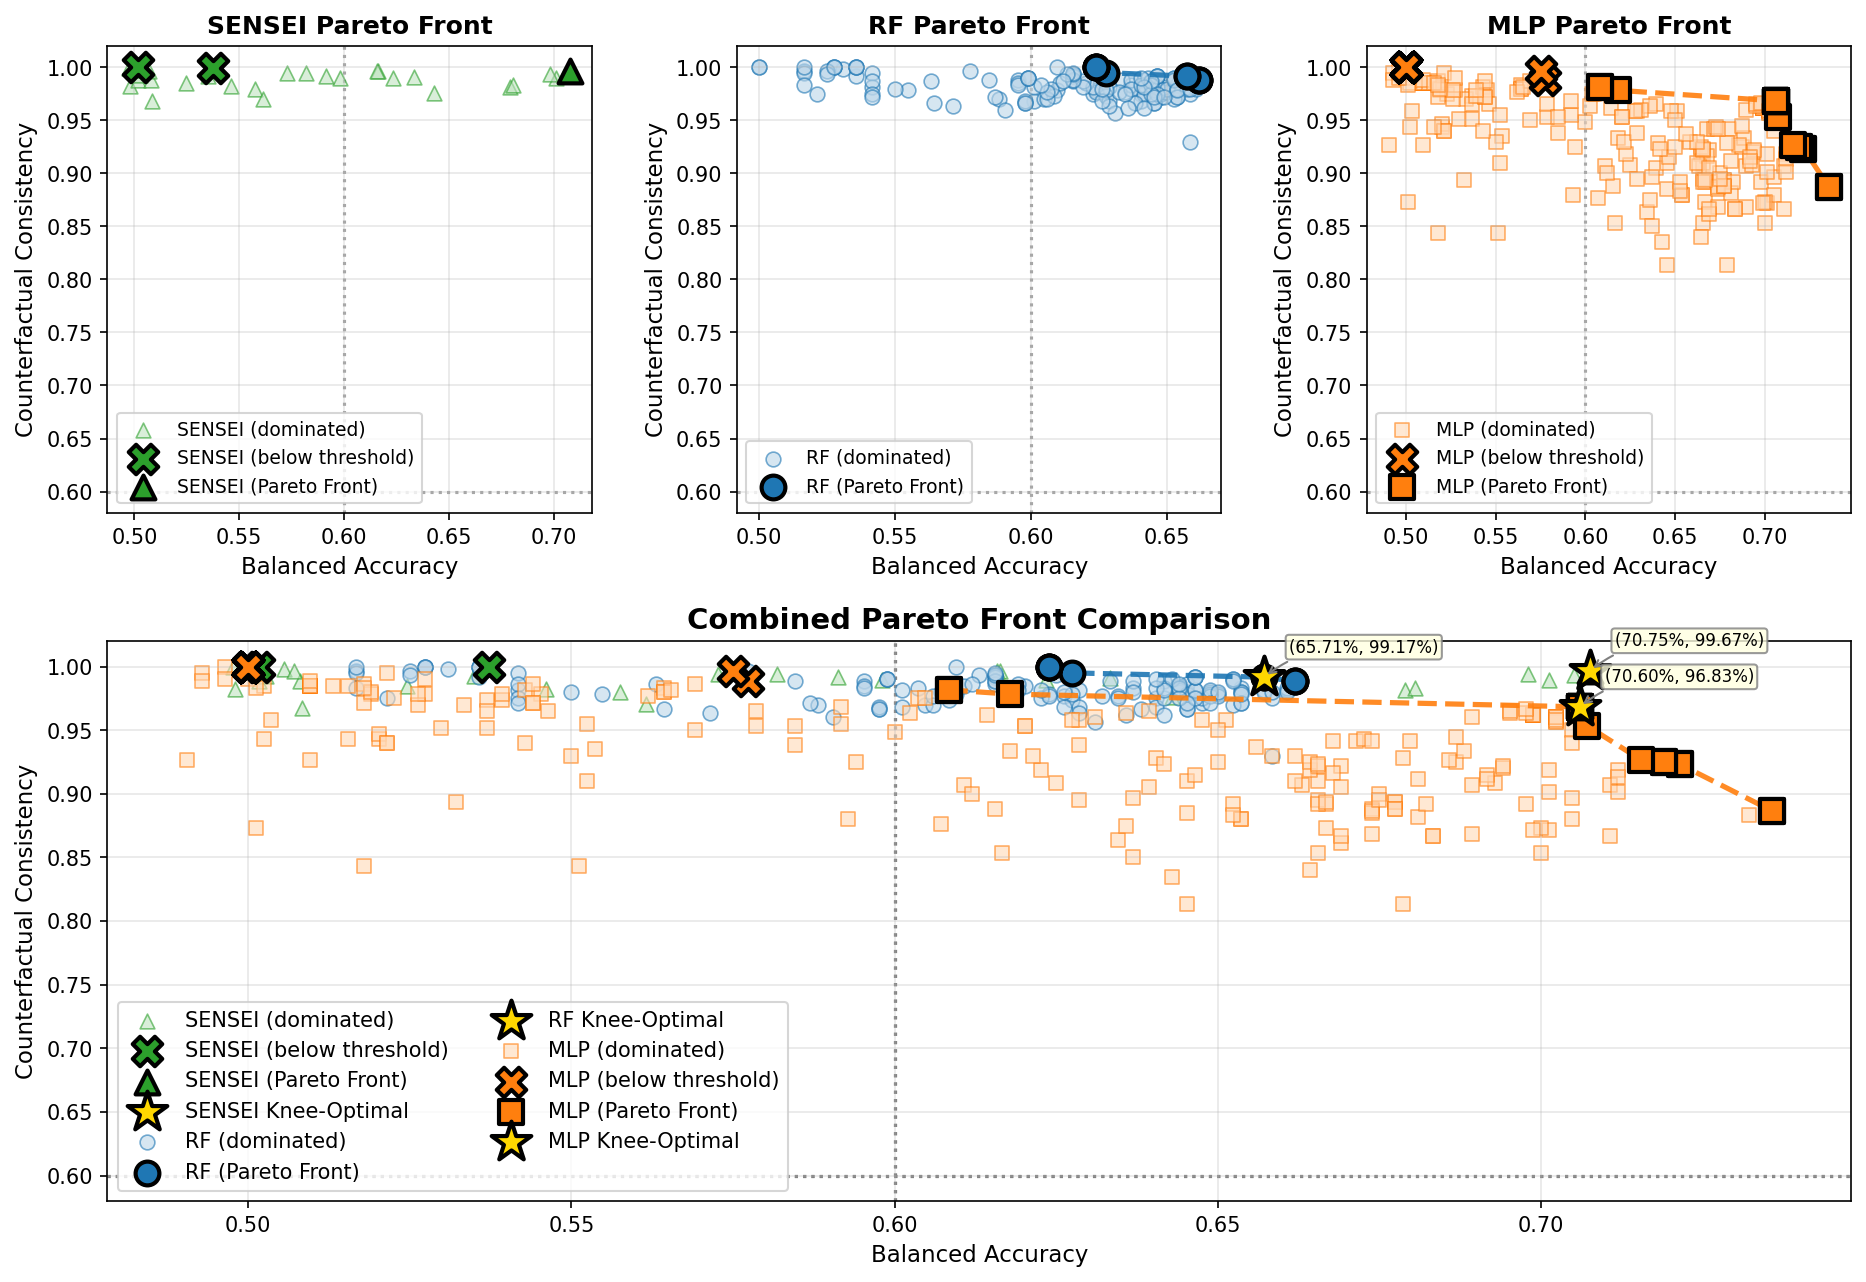

In [37]:
# 1.4b PARETO FRONT VISUALIZATION

pareto_paths = plot_and_display_pareto(
    results, 
    DATASET_NAME, 
    f"{SENSITIVE_FEATURE}_exhaustive", 
    OUTPUT_DIR,
    min_accuracy=MIN_ACCURACY,
    min_consistency=MIN_CONSISTENCY,
)

#### Parallel Coordinate Plots

Parallel coordinate plots visualize how hyperparameter configurations map to objective values.

| Element | Meaning |
|---------|---------|
| **Vertical axes** | Hyperparameters and objectives |
| **Lines** | Individual configurations |
| **Bold lines** | Pareto-optimal configurations |
| **Color** | Performance (green = better, red = worse) |

[notebook] Parallel coords saved to: ../plots/notebook/parallel_coords_german_credit_personal_status_exhaustive_sensei.png
[latex] Parallel coords saved to: ../plots/latex/parallel_coords_german_credit_personal_status_exhaustive_sensei.png

SENSEI - Parallel Coordinate Plot:


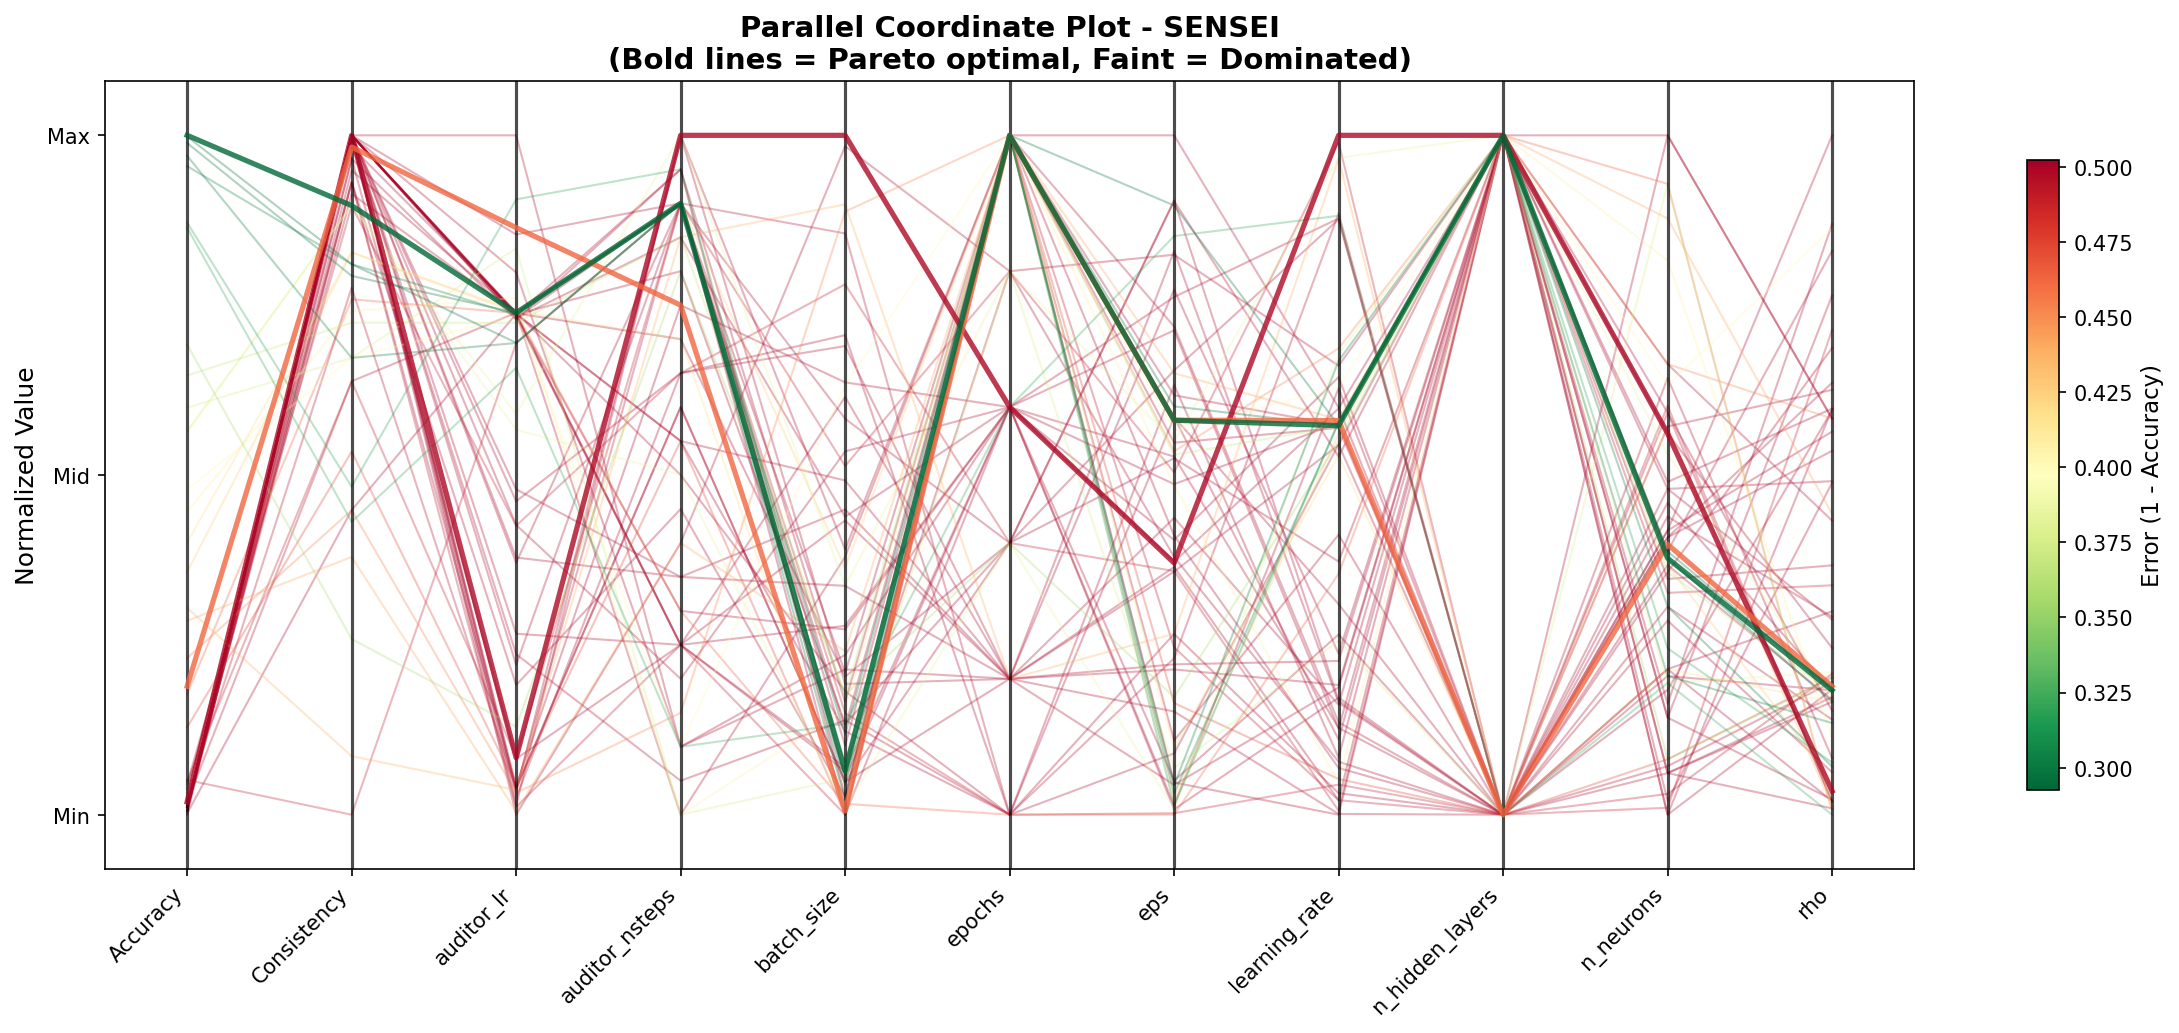

[notebook] Parallel coords saved to: ../plots/notebook/parallel_coords_german_credit_personal_status_exhaustive_rf.png
[latex] Parallel coords saved to: ../plots/latex/parallel_coords_german_credit_personal_status_exhaustive_rf.png

RF - Parallel Coordinate Plot:


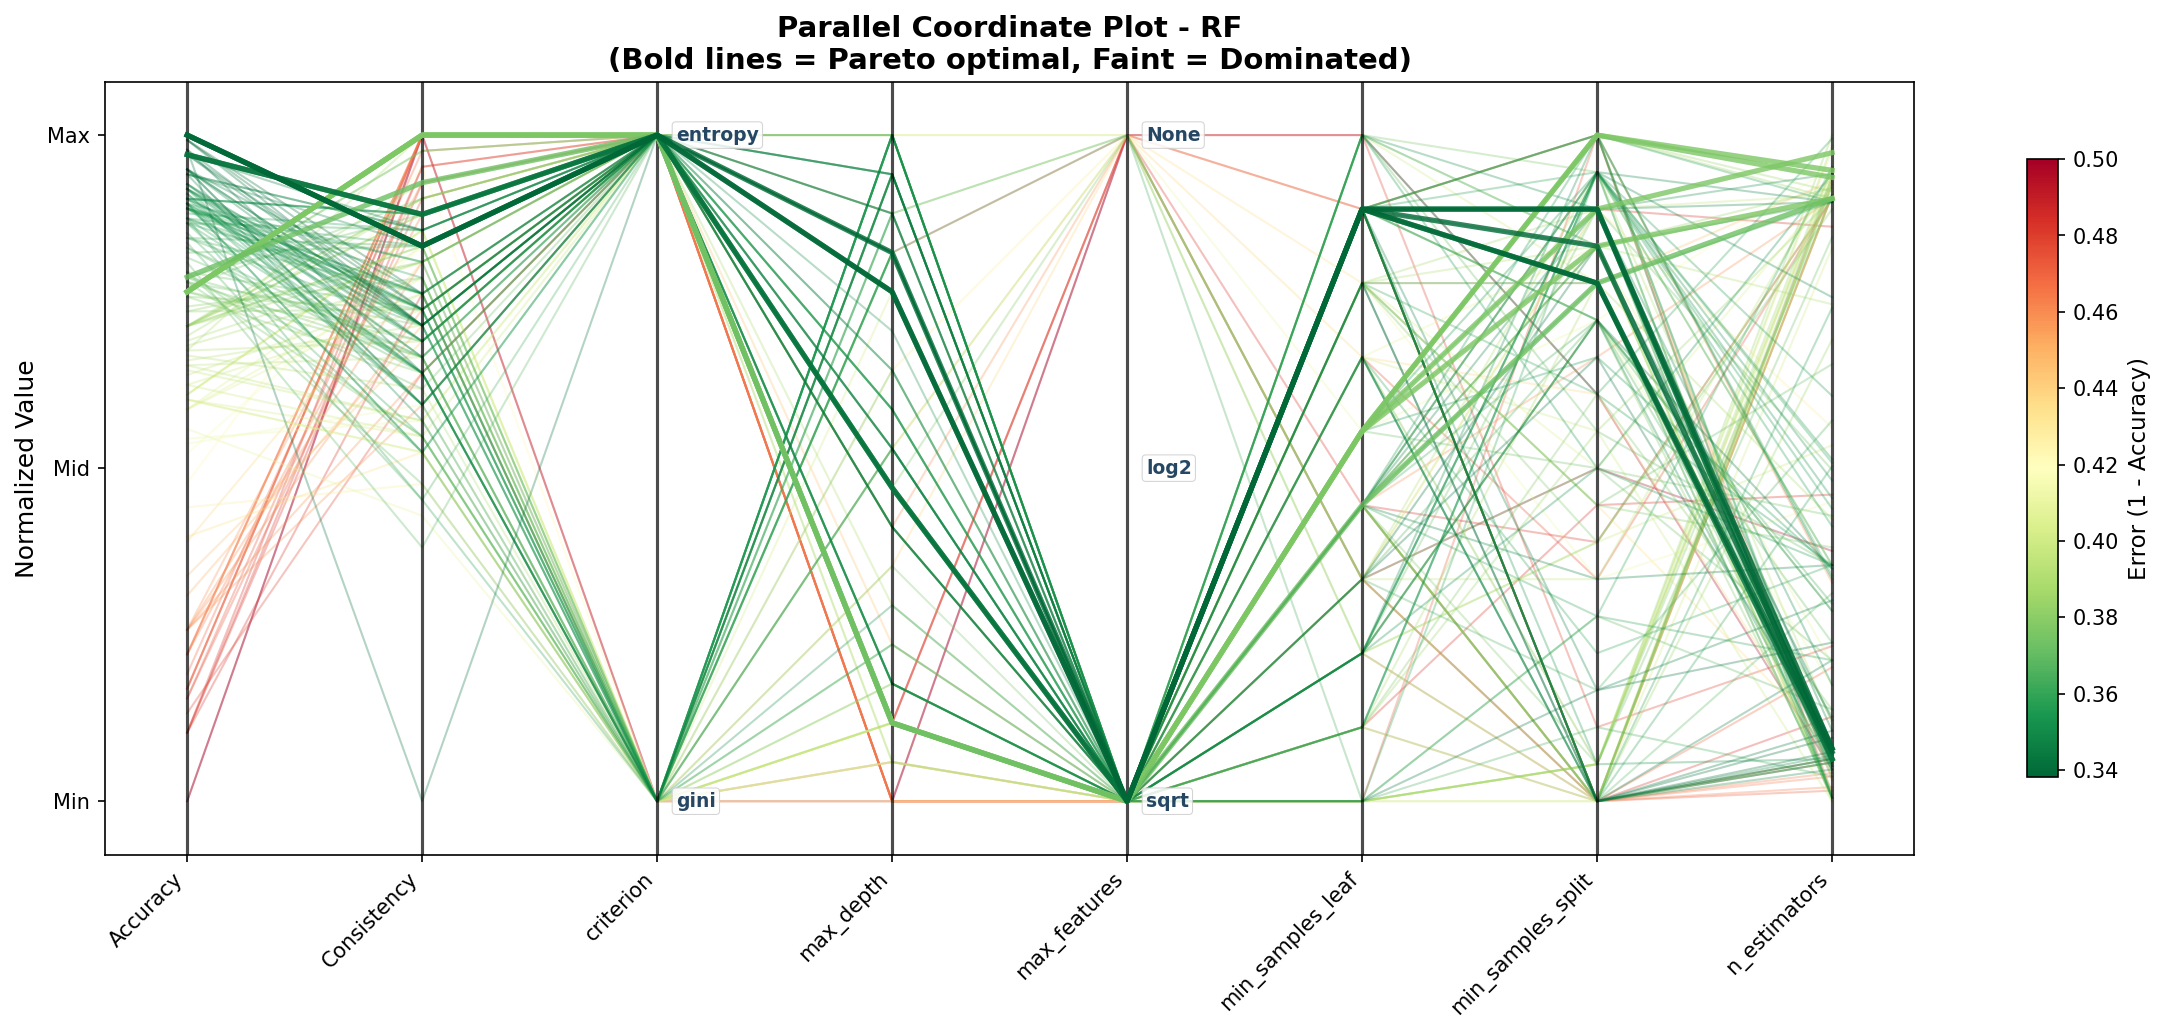

[notebook] Parallel coords saved to: ../plots/notebook/parallel_coords_german_credit_personal_status_exhaustive_mlp.png
[latex] Parallel coords saved to: ../plots/latex/parallel_coords_german_credit_personal_status_exhaustive_mlp.png

MLP - Parallel Coordinate Plot:


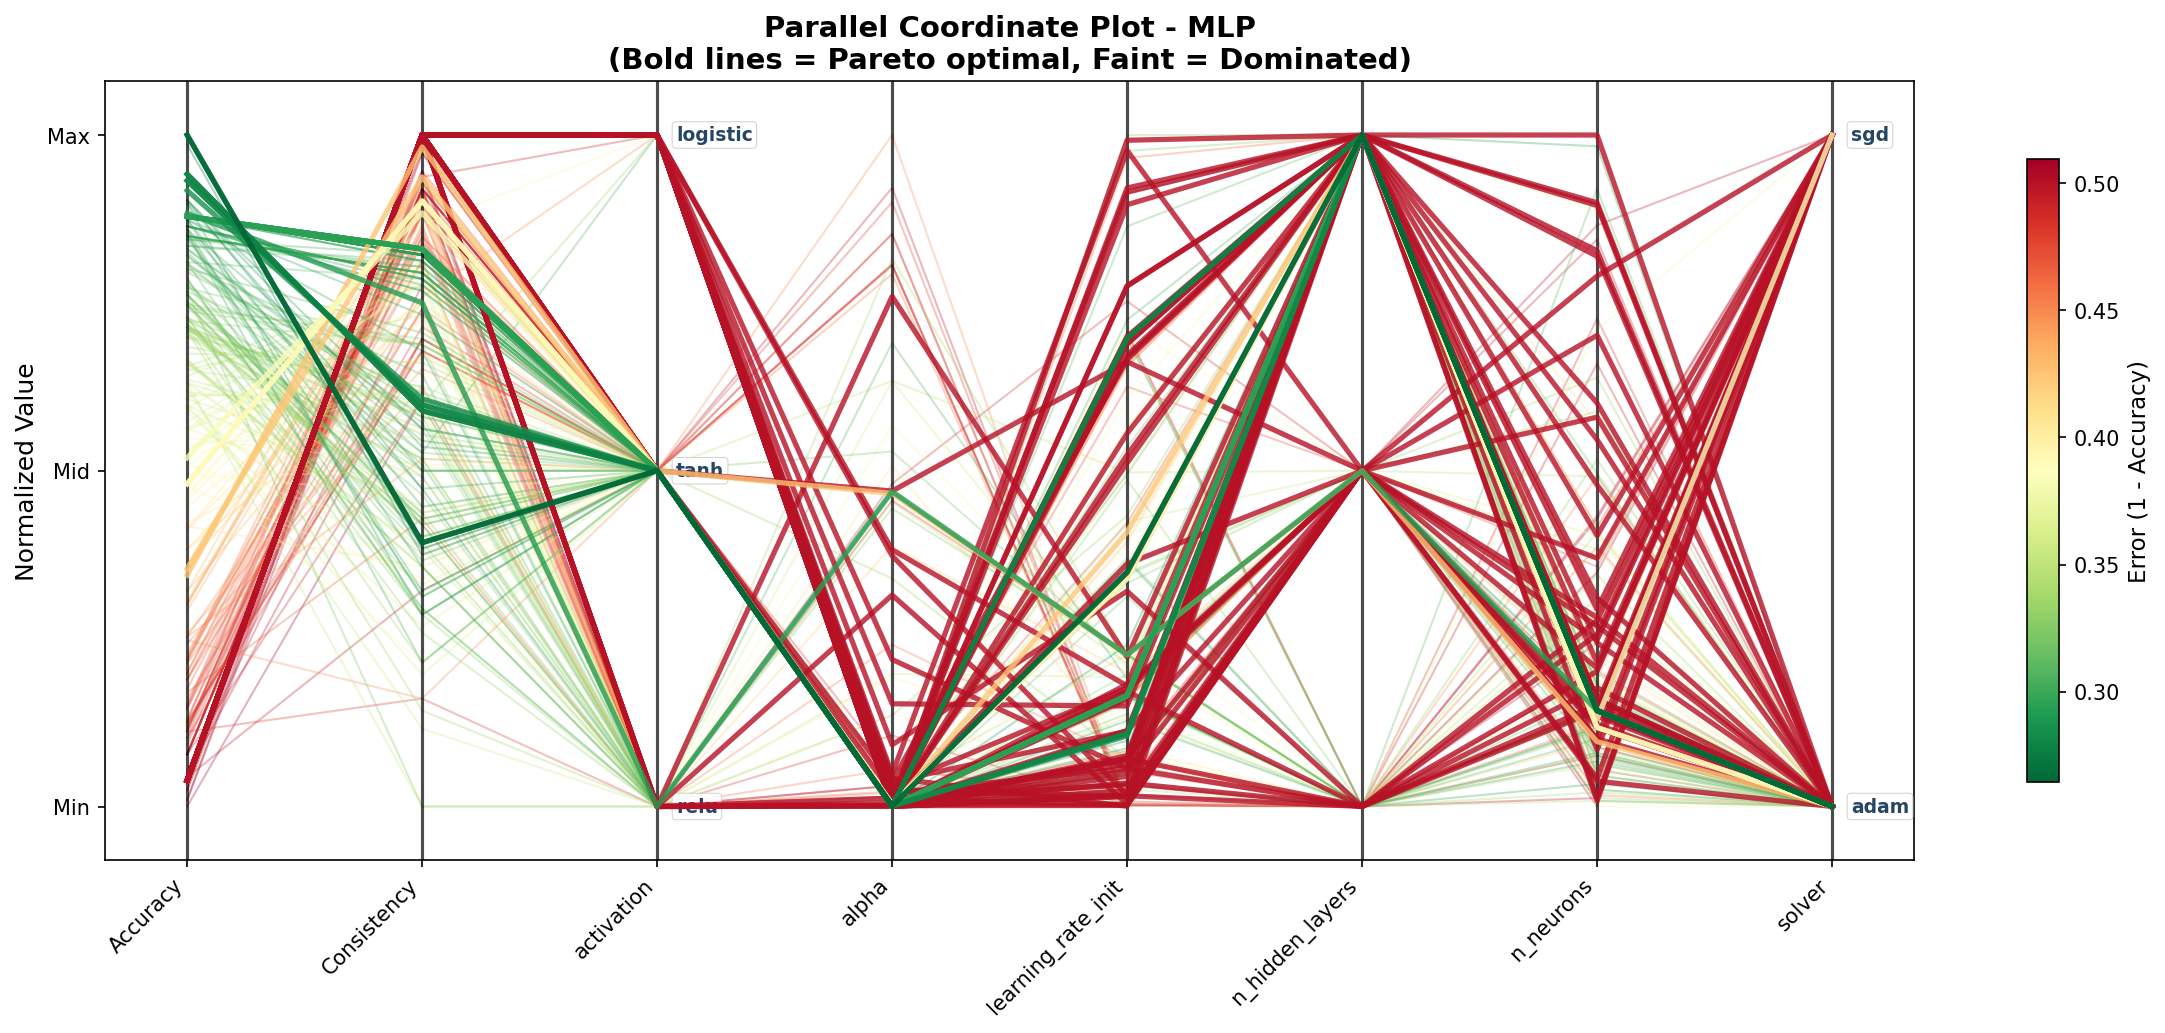

In [38]:
# 1.4c PARALLEL COORDINATE PLOTS

parallel_paths = plot_parallel_coords_all_models(
    results, 
    DATASET_NAME, 
    f"{SENSITIVE_FEATURE}_exhaustive", 
    OUTPUT_DIR
)

[notebook] MDS projection saved to: ../plots/notebook/mds_projection_german_credit_personal_status_exhaustive_sensei.png
[latex] MDS projection saved to: ../plots/latex/mds_projection_german_credit_personal_status_exhaustive_sensei.png

SENSEI - MDS Projection:


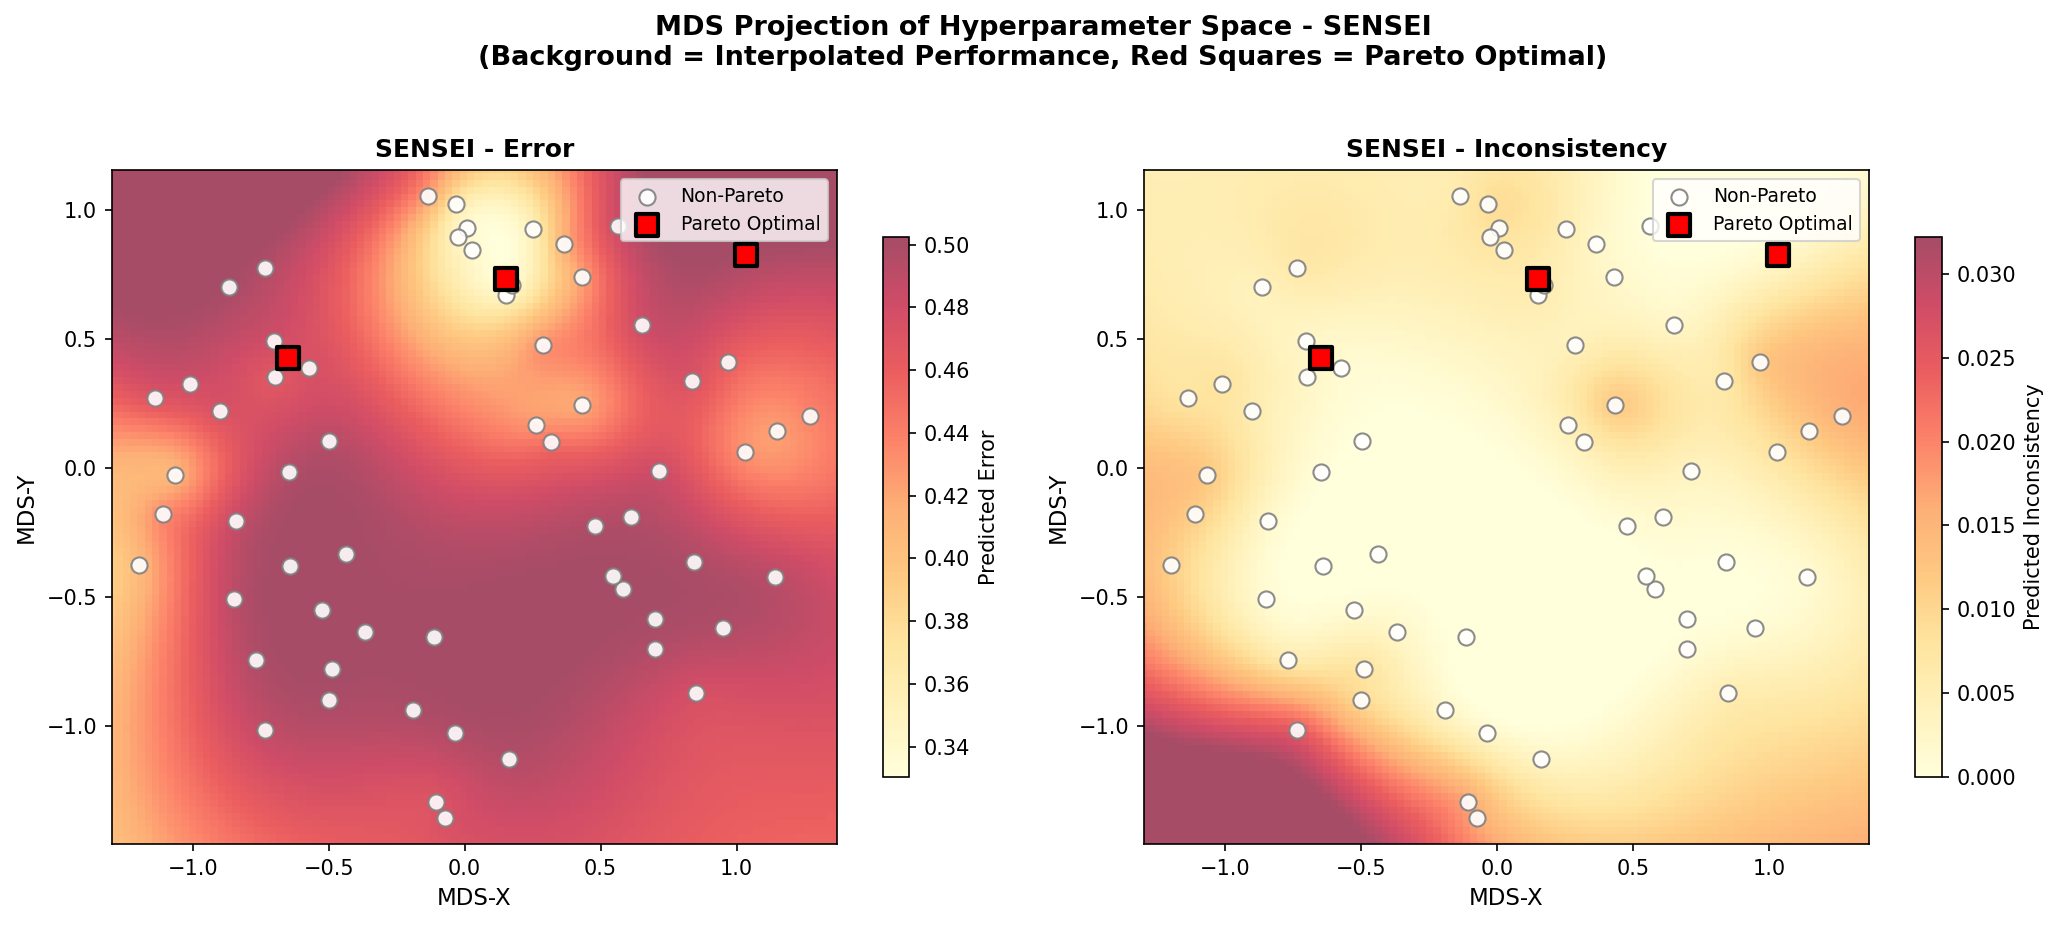

[notebook] MDS projection saved to: ../plots/notebook/mds_projection_german_credit_personal_status_exhaustive_rf.png
[latex] MDS projection saved to: ../plots/latex/mds_projection_german_credit_personal_status_exhaustive_rf.png

RF - MDS Projection:


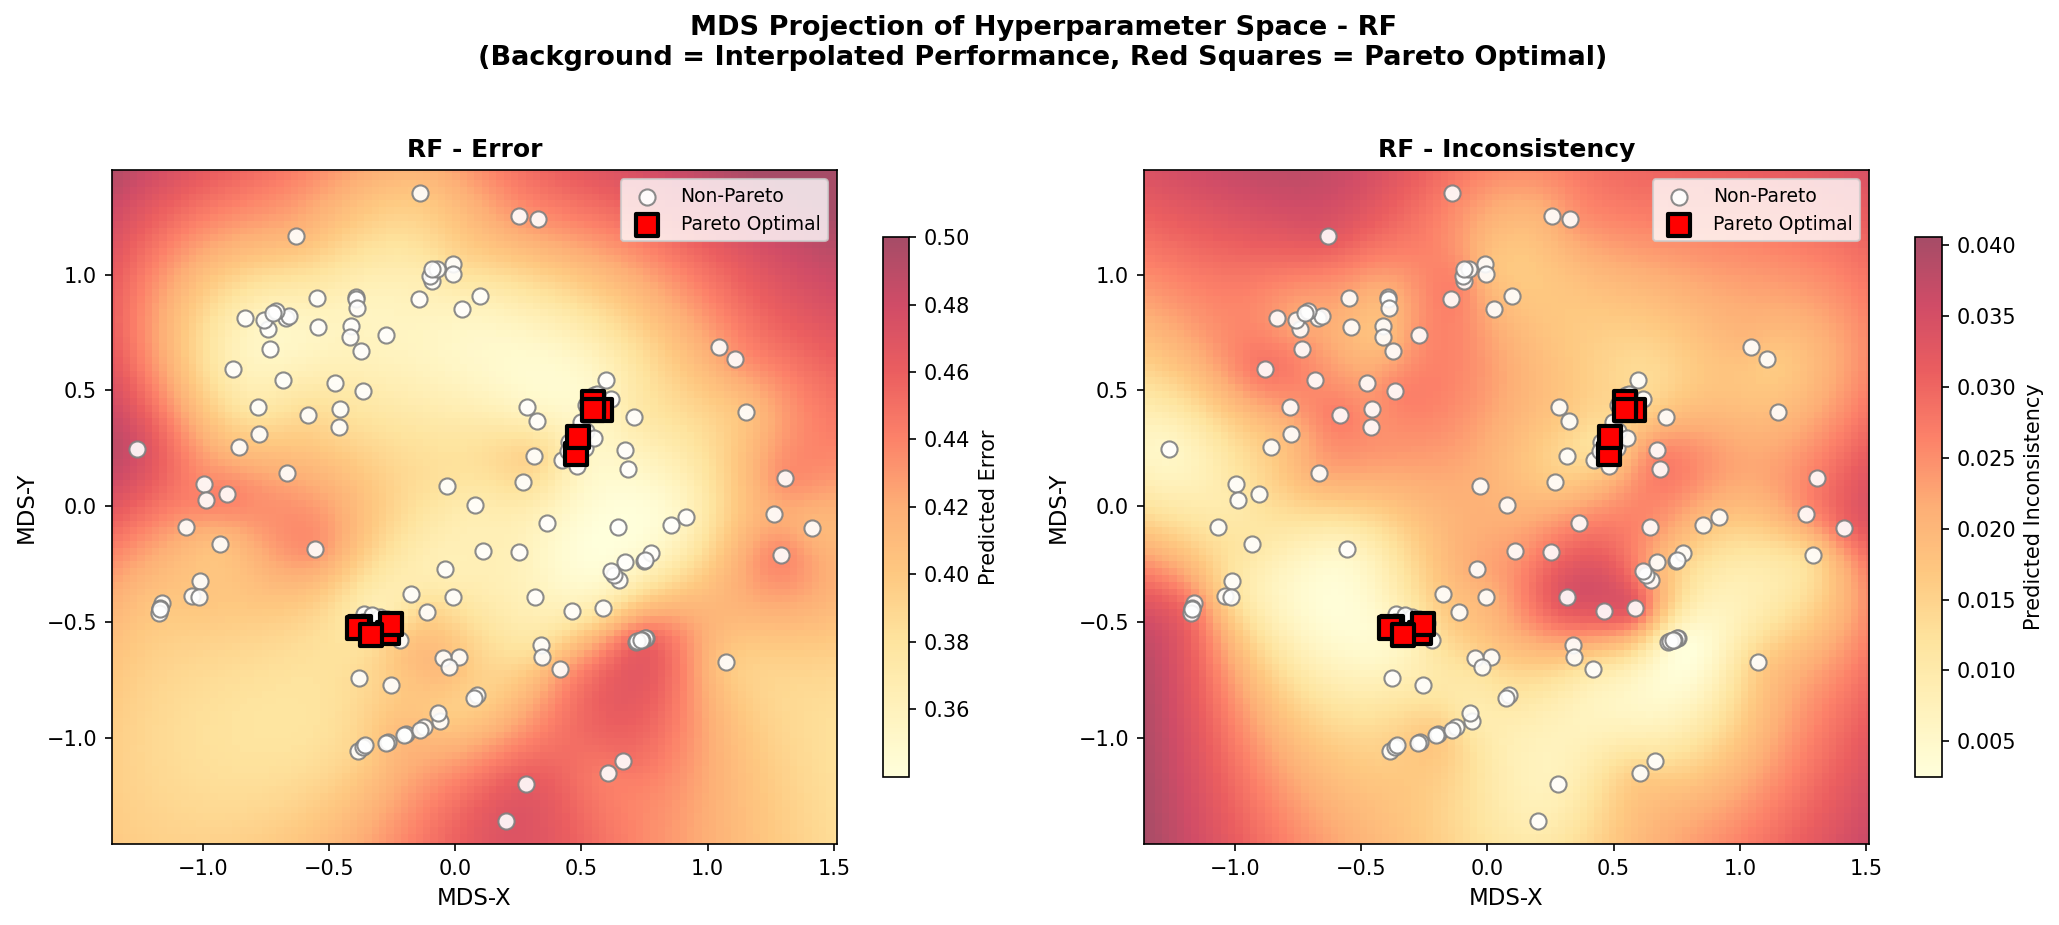

[notebook] MDS projection saved to: ../plots/notebook/mds_projection_german_credit_personal_status_exhaustive_mlp.png
[latex] MDS projection saved to: ../plots/latex/mds_projection_german_credit_personal_status_exhaustive_mlp.png

MLP - MDS Projection:


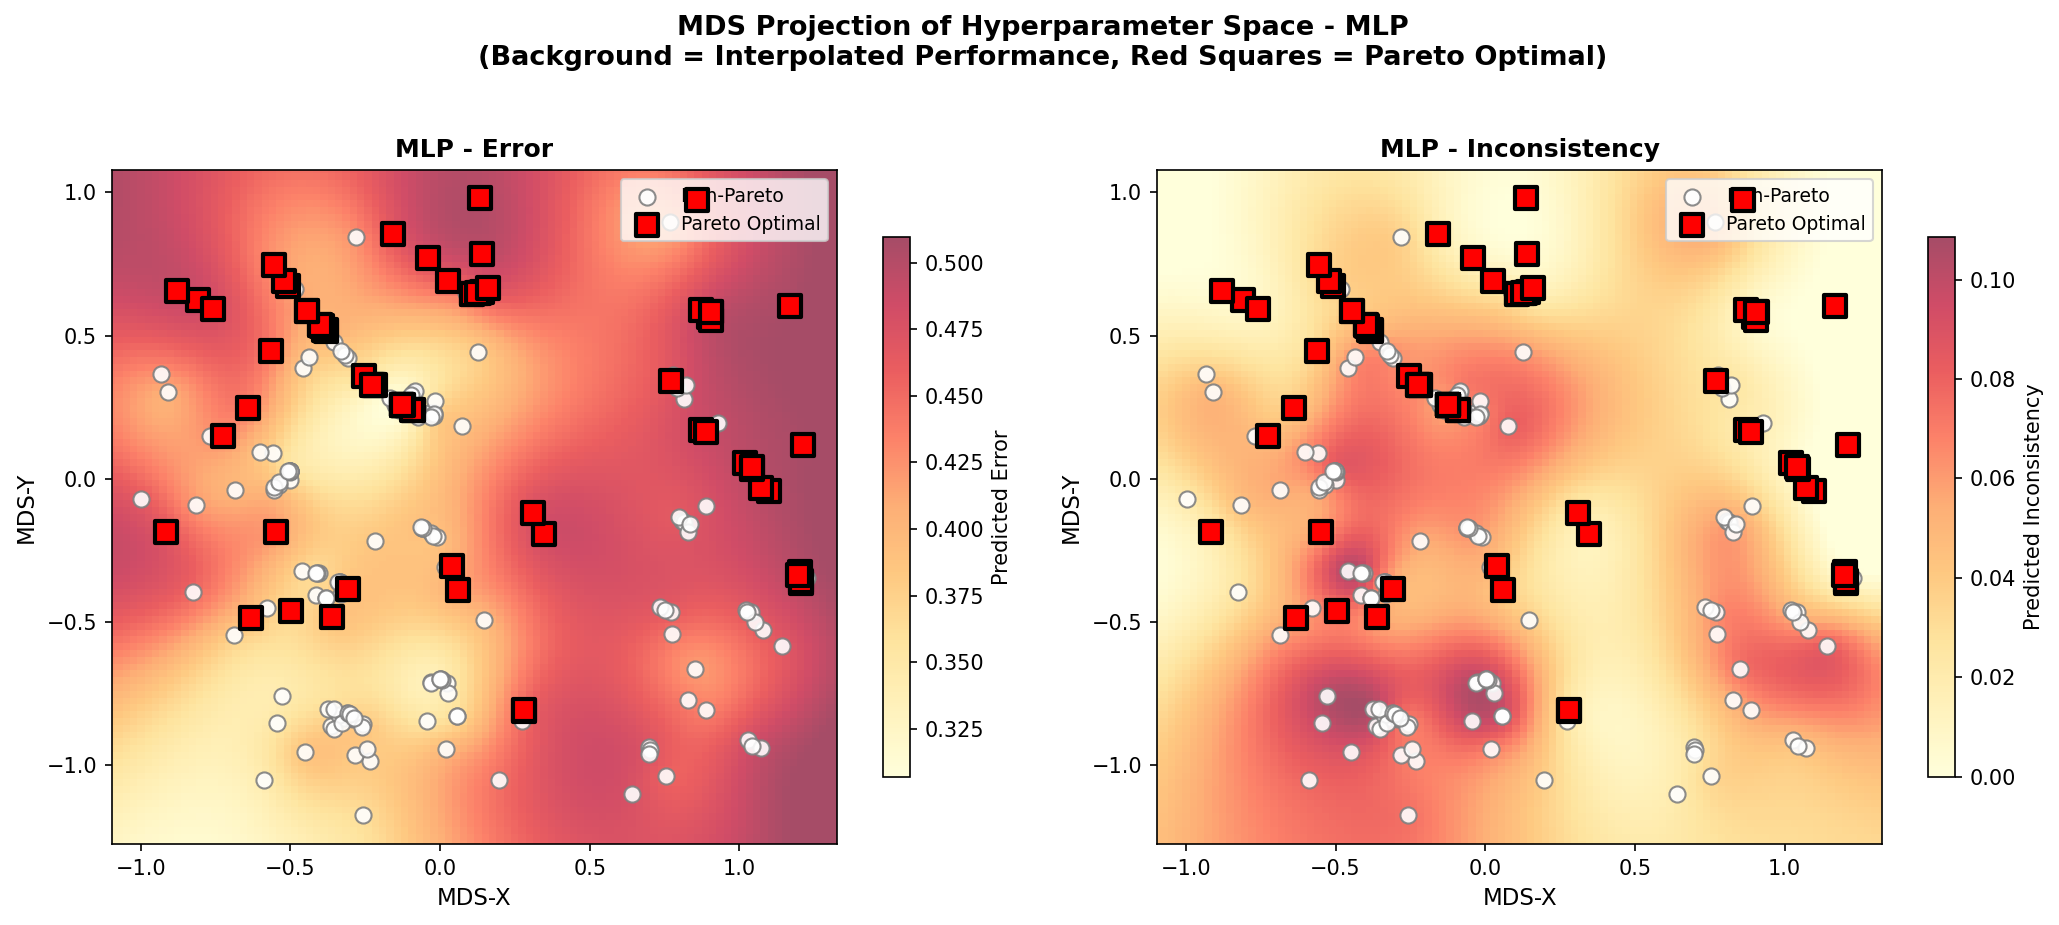

In [27]:
# 1.4d MDS PROJECTION PLOTS

mds_paths = plot_mds_all_models(
    results, 
    DATASET_NAME, 
    f"{SENSITIVE_FEATURE}_exhaustive", 
    OUTPUT_DIR
)

#### MDS Projection

Multidimensional Scaling (MDS) projects the hyperparameter space into 2D.

| Element | Meaning |
|---------|---------|
| **Points** | Hyperparameter configurations |
| **Distance** | Similarity in hyperparameter values |
| **Background** | Interpolated performance surface |
| **Red squares** | Pareto-optimal configurations |

[notebook] MDS projection saved to: ../plots/notebook/mds_projection_german_credit_personal_status_exhaustive_sensei.png
[latex] MDS projection saved to: ../plots/latex/mds_projection_german_credit_personal_status_exhaustive_sensei.png

SENSEI - MDS Projection:


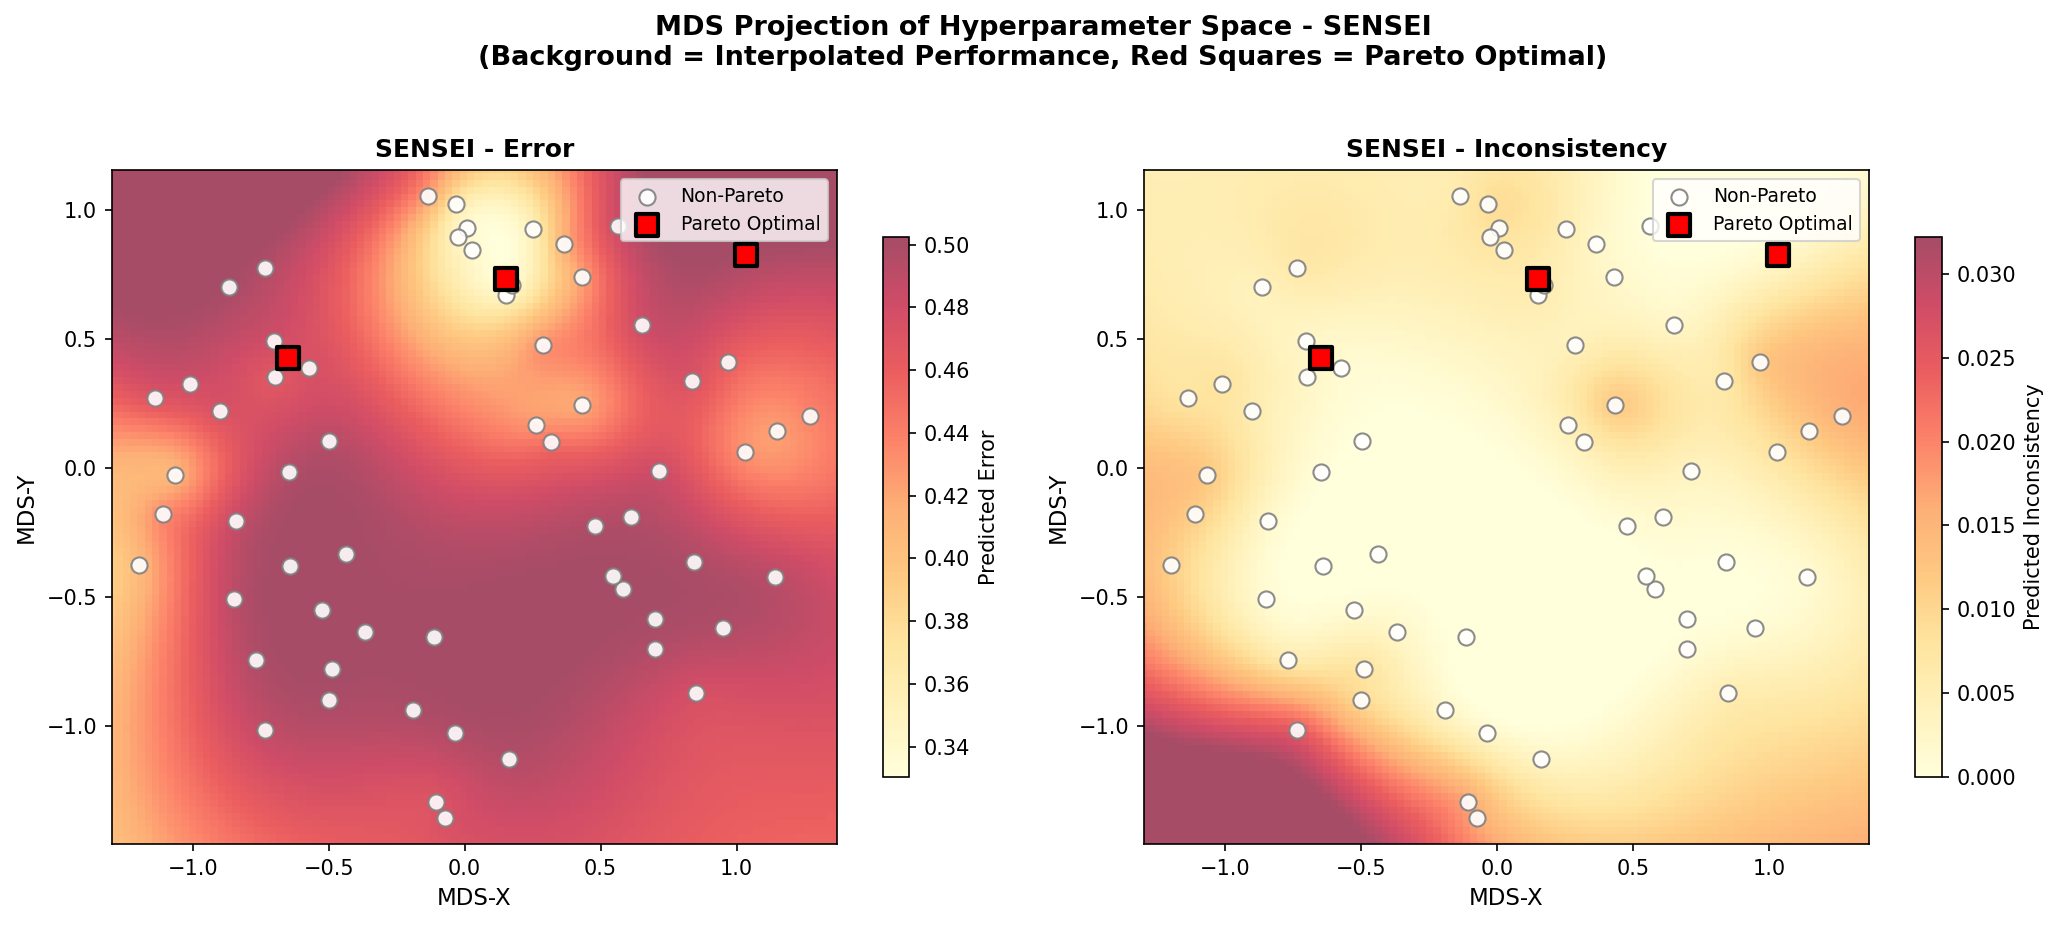

[notebook] MDS projection saved to: ../plots/notebook/mds_projection_german_credit_personal_status_exhaustive_rf.png
[latex] MDS projection saved to: ../plots/latex/mds_projection_german_credit_personal_status_exhaustive_rf.png

RF - MDS Projection:


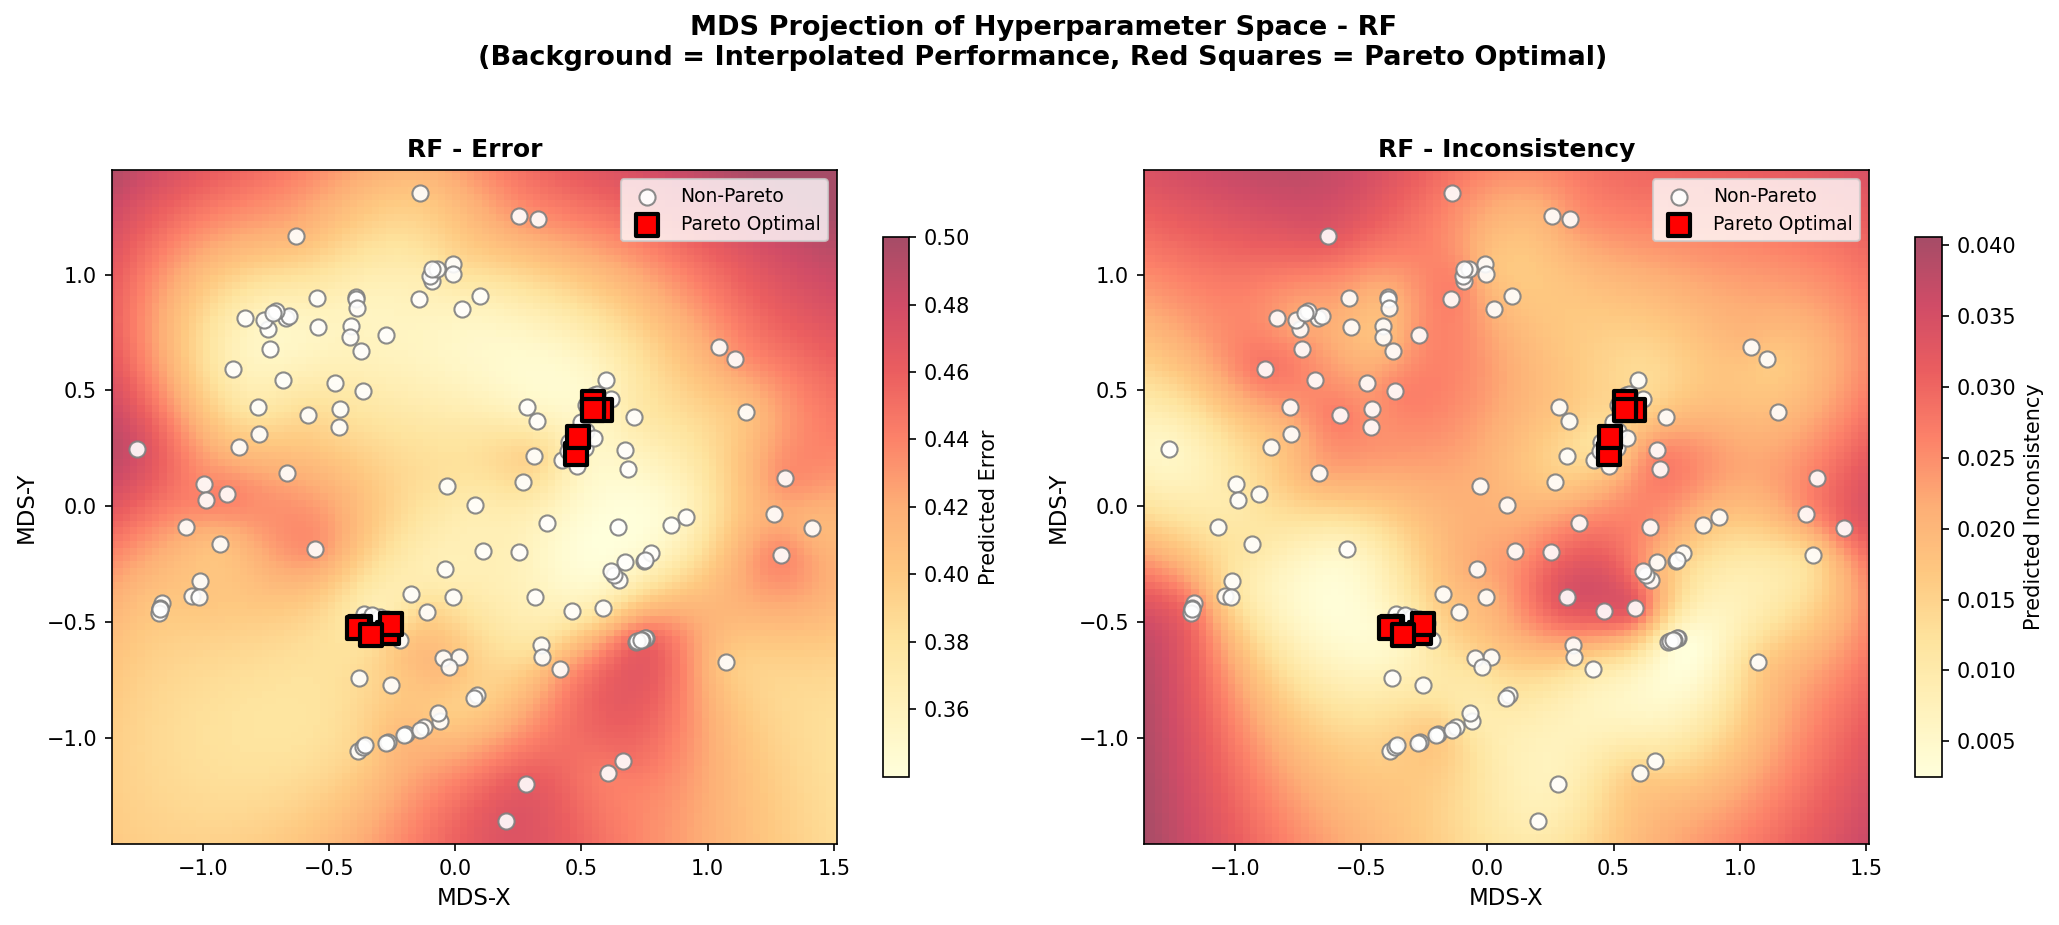

[notebook] MDS projection saved to: ../plots/notebook/mds_projection_german_credit_personal_status_exhaustive_mlp.png
[latex] MDS projection saved to: ../plots/latex/mds_projection_german_credit_personal_status_exhaustive_mlp.png

MLP - MDS Projection:


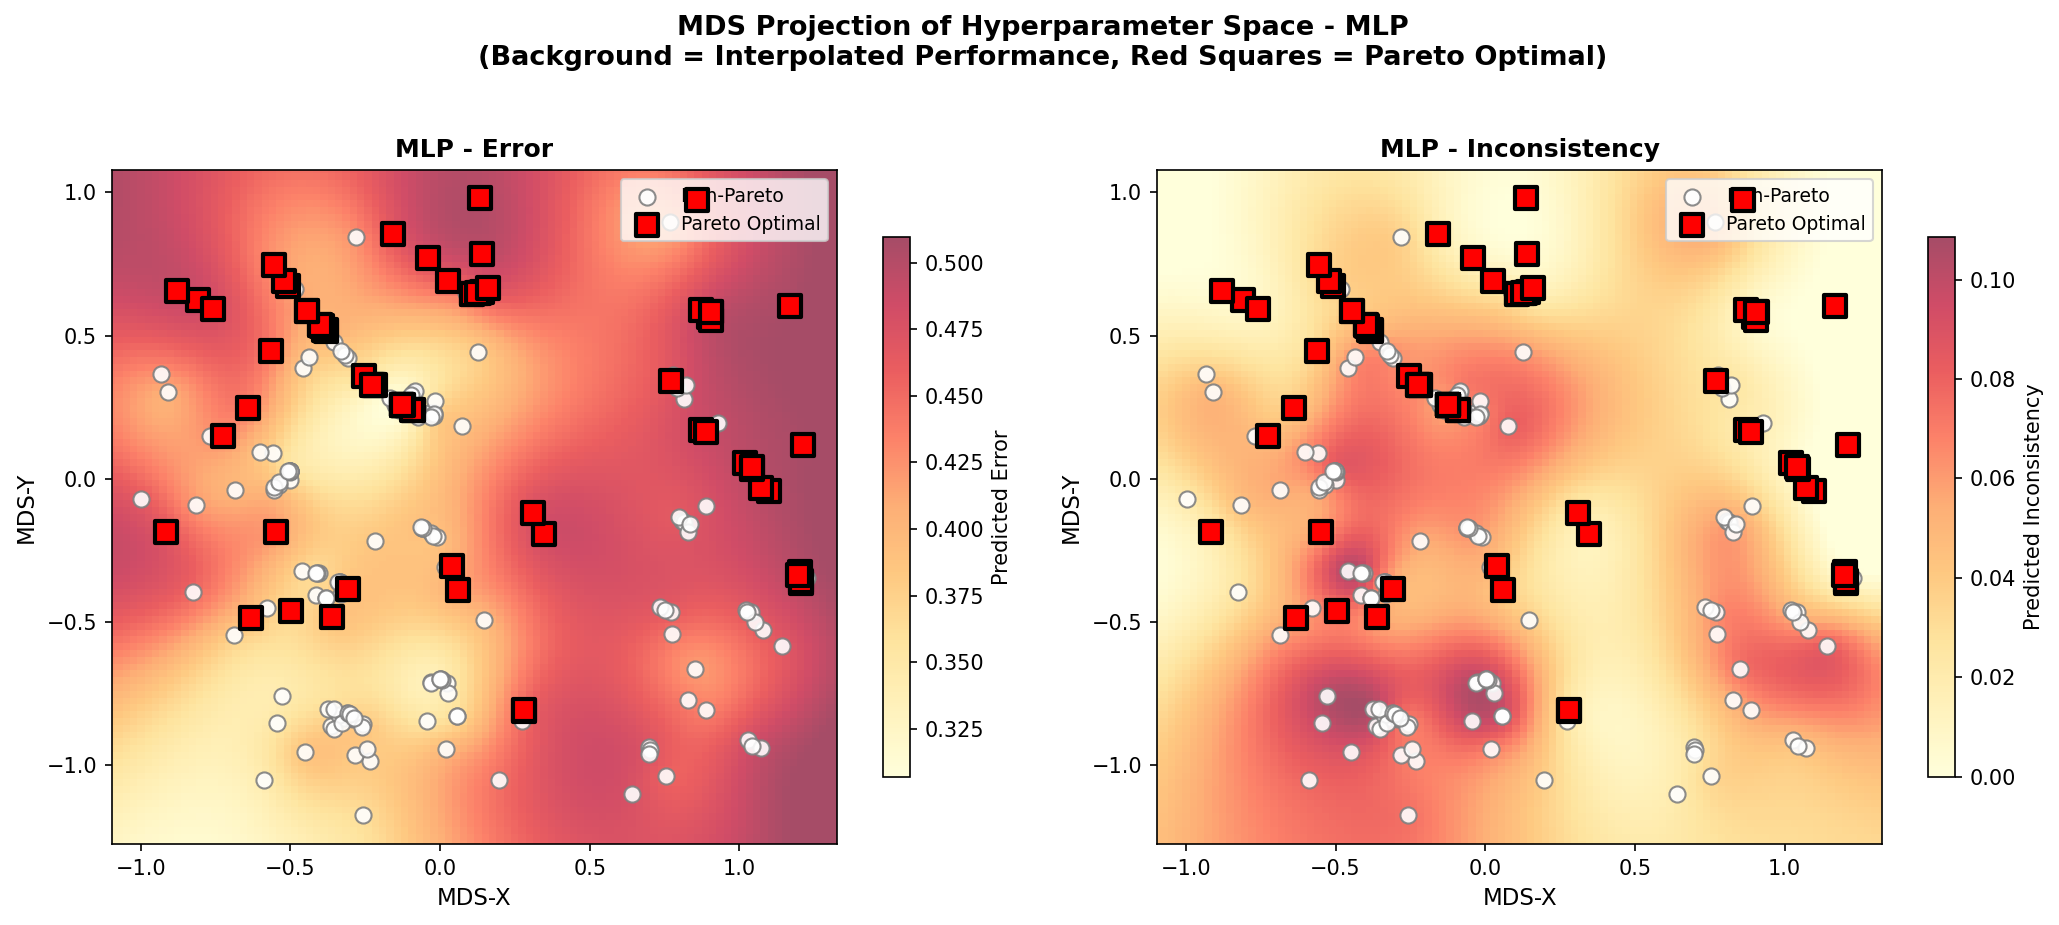

In [28]:
# 1.4d MDS PROJECTION PLOTS

mds_paths = plot_mds_all_models(
    results, 
    DATASET_NAME, 
    f"{SENSITIVE_FEATURE}_exhaustive", 
    OUTPUT_DIR
)

### 1.5 Test Set Evaluation

Final evaluation on the held-out test set using **knee-optimal configurations**.

**Models compared:**
- **Random Forest (RF)** — Traditional ML baseline
- **MLP** — Neural network baseline  
- **SenSeI** — In-training individual fairness method

**Metrics:**
- **Accuracy / Balanced Accuracy** — Prediction performance
- **Counterfactual Consistency** — Fairness across all `personal_status` categories

FINAL TEST SET EVALUATION (Multiclass Exhaustive)

──────────────────────────────────────────────────────────────────────
SENSEI - Knee-Optimal Configuration
──────────────────────────────────────────────────────────────────────
  Validation: Accuracy=0.7075, Consistency=0.9967
  Note: Using validation metrics for SenSeI

──────────────────────────────────────────────────────────────────────
RF - Knee-Optimal Configuration
──────────────────────────────────────────────────────────────────────
  Validation: Accuracy=0.6571, Consistency=0.9917
  Points meeting threshold: 10/10

  TEST SET RESULTS:
  Accuracy:          0.7150 (71.50%)
  Balanced Accuracy: 0.6202 (62.02%)
  Consistency:       0.9833 (98.33%)
  Test samples:      200

──────────────────────────────────────────────────────────────────────
MLP - Knee-Optimal Configuration
──────────────────────────────────────────────────────────────────────
  Validation: Accuracy=0.7060, Consistency=0.9683
  Points meeting threshold: 17/74



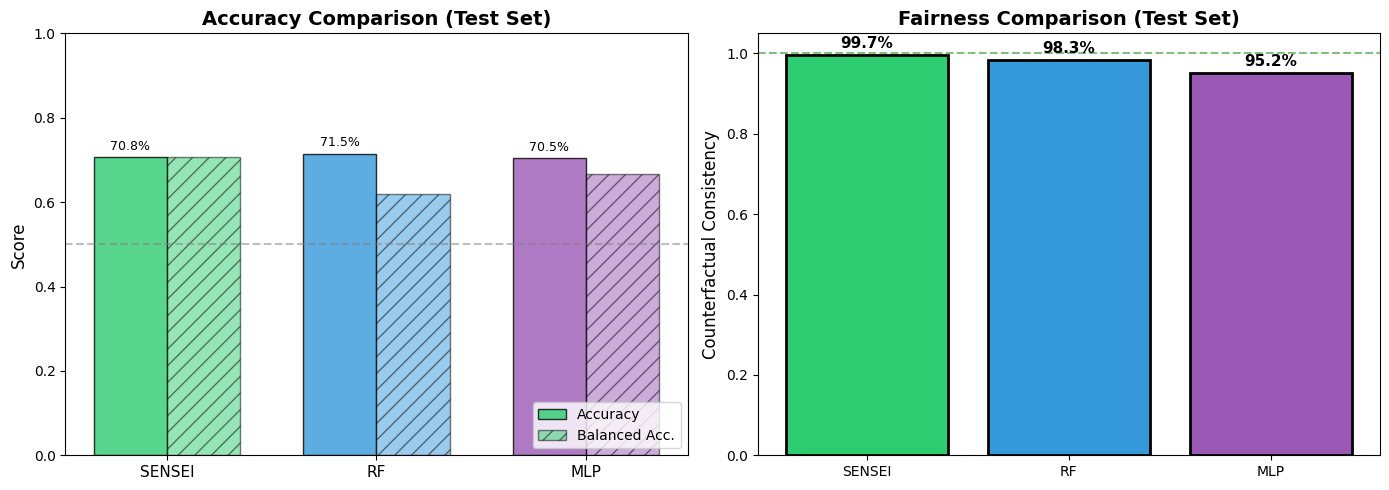


✓ Comparison plot saved to ../plots/


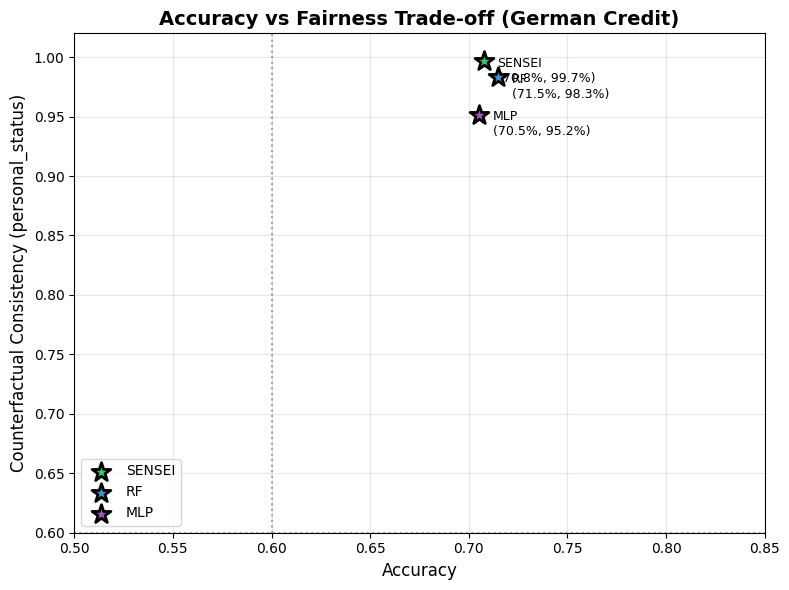

✓ Trade-off plot saved to ../plots/


In [36]:
# 1.5 TEST SET EVALUATION

from sklearn.metrics import accuracy_score, balanced_accuracy_score
from utils.analysis import select_balanced_pareto_point

print("="*70)
print("FINAL TEST SET EVALUATION (Multiclass Exhaustive)")
print("="*70)

test_results = {}

# Prepare sensitive features info
sensitive_features_info = data['sensitive_features_info']

for model_type in results.keys():
    print(f"\n{'─'*70}")
    print(f"{model_type.upper()} - Knee-Optimal Configuration")
    print(f"{'─'*70}")
    
    # Get knee-optimal config from Pareto front (WITH THRESHOLDS)
    configs, costs = get_pareto_front(results[model_type])
    
    # Pass thresholds to be consistent with Pareto plot
    knee_idx, knee_info = select_balanced_pareto_point(
        configs, costs, method='knee',
        min_accuracy=MIN_ACCURACY, min_consistency=MIN_CONSISTENCY
    )
    
    # Handle case where no points meet threshold
    if knee_idx is None:
        print(f"  ⚠️ No Pareto points meet thresholds (acc>={MIN_ACCURACY}, con>={MIN_CONSISTENCY})")
        print(f"  Using best available point from all Pareto points...")
        knee_idx, knee_info = select_balanced_pareto_point(configs, costs, method='knee')
    
    knee_config = configs[knee_idx]
    
    print(f"  Validation: Accuracy={knee_info['accuracy']:.4f}, Consistency={knee_info['consistency']:.4f}")
    if 'valid_count' in knee_info:
        print(f"  Points meeting threshold: {knee_info['valid_count']}/{len(configs)}")
    
    # Create and train model
    if model_type == "rf":
        model = create_rf_model(knee_config)
        model.fit(data['X_train'], data['y_train'])
    elif model_type == "mlp":
        model = create_mlp_model(knee_config)
        model.fit(data['X_train'], data['y_train'])
    else:  # sensei
        print(f"  Note: Using validation metrics for SenSeI")
        test_results[model_type] = {
            'accuracy': knee_info['accuracy'],
            'balanced_accuracy': knee_info['accuracy'],
            'consistency': knee_info['consistency'],
            'val_accuracy': knee_info['accuracy'],
            'val_consistency': knee_info['consistency'],
            'note': 'validation_metrics'
        }
        continue
    
    # Evaluate on TEST set
    y_pred_test = model.predict(data['X_test'])
    y_true_test = data['y_test']
    
    # Accuracy metrics
    acc = accuracy_score(y_true_test, y_pred_test)
    bal_acc = balanced_accuracy_score(y_true_test, y_pred_test)
    
    # Multi-sensitive exhaustive counterfactual consistency
    flipped_versions, combo_labels, orig_combos = create_flipped_data_multi_sensitive_exhaustive(
        data['X_test'], sensitive_features_info
    )
    y_preds_flipped = [model.predict(X_flip) for X_flip in flipped_versions]
    consistency = counterfactual_consistency_multi_sensitive_exhaustive(
        y_pred_test, y_preds_flipped, orig_combos
    )
    
    # Store results
    test_results[model_type] = {
        'accuracy': acc,
        'balanced_accuracy': bal_acc,
        'consistency': consistency,
        'val_accuracy': knee_info['accuracy'],
        'val_consistency': knee_info['consistency'],
    }
    
    # Print results
    print(f"\n  TEST SET RESULTS:")
    print(f"  Accuracy:          {acc:.4f} ({acc:.2%})")
    print(f"  Balanced Accuracy: {bal_acc:.4f} ({bal_acc:.2%})")
    print(f"  Consistency:       {consistency:.4f} ({consistency:.2%})")
    print(f"  Test samples:      {len(y_true_test):,}")

# SUMMARY TABLE
print(f"\n{'='*70}")
print("SUMMARY - TEST SET (Multiclass Exhaustive)")
print(f"{'='*70}")
print(f"{'Model':<10} {'Accuracy':>12} {'Bal. Acc.':>12} {'Consistency':>12}")
print("-"*50)
for model_type, res in test_results.items():
    print(f"{model_type.upper():<10} {res['accuracy']:>12.2%} {res['balanced_accuracy']:>12.2%} {res['consistency']:>12.2%}")

# COMPARISON VISUALIZATION
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

models = list(test_results.keys())
model_labels = [m.upper() for m in models]
colors = ['#2ecc71', '#3498db', '#9b59b6'][:len(models)]  # RF=green, MLP=blue, SenSeI=purple

# Plot 1: Accuracy comparison
accuracies = [test_results[m]['accuracy'] for m in models]
bal_accuracies = [test_results[m]['balanced_accuracy'] for m in models]

x = np.arange(len(models))
width = 0.35

bars1 = axes[0].bar(x - width/2, accuracies, width, label='Accuracy', color=colors, alpha=0.8, edgecolor='black')
bars2 = axes[0].bar(x + width/2, bal_accuracies, width, label='Balanced Acc.', color=colors, alpha=0.5, edgecolor='black', hatch='//')

axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Accuracy Comparison (Test Set)', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(model_labels, fontsize=11)
axes[0].legend(loc='lower right')
axes[0].set_ylim(0, 1)
axes[0].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)

for bar in bars1:
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f'{bar.get_height():.1%}', ha='center', va='bottom', fontsize=9)

# Plot 2: Consistency comparison
consistencies = [test_results[m]['consistency'] for m in models]

bars3 = axes[1].bar(model_labels, consistencies, color=colors, edgecolor='black', linewidth=2)
axes[1].set_ylabel('Counterfactual Consistency', fontsize=12)
axes[1].set_title('Fairness Comparison (Test Set)', fontsize=14, fontweight='bold')
axes[1].set_ylim(0, 1.05)
axes[1].axhline(y=1.0, color='green', linestyle='--', alpha=0.5)

for bar in bars3:
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                 f'{bar.get_height():.1%}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/notebook/test_comparison_{DATASET_NAME}.png', dpi=150, bbox_inches='tight')
plt.savefig(f'{OUTPUT_DIR}/latex/test_comparison_{DATASET_NAME}.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Comparison plot saved to {OUTPUT_DIR}/")

# TRADE-OFF SCATTER PLOT
fig, ax = plt.subplots(figsize=(8, 6))

for i, model_type in enumerate(models):
    res = test_results[model_type]
    ax.scatter(res['accuracy'], res['consistency'], 
               c=colors[i], s=200, marker='*', edgecolors='black', linewidths=2,
               label=f"{model_type.upper()}", zorder=3)
    ax.annotate(f"{model_type.upper()}\n({res['accuracy']:.1%}, {res['consistency']:.1%})",
                xy=(res['accuracy'], res['consistency']),
                xytext=(10, -15), textcoords='offset points',
                fontsize=9, ha='left')

ax.set_xlabel('Accuracy', fontsize=12)
ax.set_ylabel('Counterfactual Consistency (personal_status)', fontsize=12)
ax.set_title(f'Accuracy vs Fairness Trade-off (German Credit)', fontsize=14, fontweight='bold')
ax.legend(loc='lower left')
ax.grid(True, alpha=0.3)
ax.set_xlim(0.5, 0.85)
ax.set_ylim(0.6, 1.02)

# Add threshold lines
ax.axvline(x=MIN_ACCURACY, color='gray', linestyle=':', alpha=0.7, linewidth=1.5)
ax.axhline(y=MIN_CONSISTENCY, color='gray', linestyle=':', alpha=0.7, linewidth=1.5)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/notebook/tradeoff_{DATASET_NAME}.png', dpi=150, bbox_inches='tight')
plt.savefig(f'{OUTPUT_DIR}/latex/tradeoff_{DATASET_NAME}.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Trade-off plot saved to {OUTPUT_DIR}/")